## Math 360 Group Assignment 2 - Stochastic Models
Autum Cheung, Merlin Reinders, Liyuan Ding, Éabha Farrell

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
from scipy.stats import norm
import scipy.stats as stats
import pandas as pd
%matplotlib inline

print("packages imported")

packages imported


#### Problem Statement
Model how the weather affects the annual income of Loafe Café, UBC. 

## Variables and Parameters ##
|                        Description                        |    Symbol     |Dimension|               Type                |
|:---------------------------------------------------------:|:-------------:|:---:|:---------------------------------:|
|                 Average Daily Temperature                 |      $T$      |1|          Random Variable          |
|                   Reference Temperature                   |     $T_0$     |1|             Parameter             |
|                      Daily Humidity                       |      $H$      |1|          Random Variable          |
|                    Reference Humidity                     |     $H_0$     |1|             Parameter             |
|                    Daily Precipitation                    |      $P$      |1|          Random Variable          |
|                  Reference Precipitation                  |     $P_0$     |1|             Parameter             |
|                    Number of Customers                    |      $C$      |1| Dependent Variable (model output) |
|                 Reference no. of Customers                |      $C_0$    |1|             Parameter             |
|  Rate of Change of Customers with respect to temperature  |      $a$      |1|             Parameter             |
| Rate of Change of Customers with respect to precipitation |      $b$      |1|             Parameter             |
|   Rate of Change of Customers with respect to humidity    |      $c$      |1|             Parameter             |
|               Average of Random Variable i                |   $\mu _i$    |1|             Parameter             |
|               Variance of Random Variable i               | $\sigma _i^2$ |1|             Parameter             |

#### Assumptions and constraints:
- The variables $T$, $P$, and $H$ are random and distributed according to normally, exponentially and normally, respectively
- The café doesn't run out of food / drinks
- Café is open every day (except for university closures, which we assume to be the 11 statutory holidays in BC)
- Weather and number of customers is consistent with the prompt 

#### Building the Solution

In [2]:
data_weather = pd.read_csv('weatherstats_vancouver_daily_2025.csv')
data_customers = pd.read_csv('customer_data_2025.csv')

df_weather = pd.DataFrame(data_weather)
df_customers = pd.DataFrame(data_customers)

We will not include the plots because of space constraints, but we found the temperature to be bimodally distributed, with peaks that presumably correspond to summer and winter highs. We model it here as a normal distribution with mean $10.6$ and standard deviation $5.84$, for ease, but this is an assumption that will lead to error and should be rolled back for a more complete model. 
We found the precipitation to be approximately exponentially distributed, with $\lambda = 6.473$ (although a gamma distribution would perhaps be more accurate here). 
We found the humidity to be modelled well with a normal distribution, with a mean of $78.1$ and standard deviation $9.46$. 

In [4]:
jan_daily_mean_alum = df_customers['January_Frequency_Customers_Alumni_Centre'].sum() / 30 
# one public holiday in january -> open 30/31 days, same in july
jan_daily_mean_sauder = df_customers['January_Frequency_Customers_Sauder'].sum() / 30
july_daily_mean_alum = df_customers['July_Frequency_Customers_Alumni_Centre'].sum() / 30 
july_daily_mean_sauder = df_customers['July_Frequency_Customers_Sauder'].sum() / 30

# overall daily means
jan_daily_mean = (df_customers['January_Frequency_Customers_Alumni_Centre'].sum() + df_customers['January_Frequency_Customers_Sauder'].sum()) / 30
july_daily_mean = (df_customers['July_Frequency_Customers_Alumni_Centre'].sum() + df_customers['July_Frequency_Customers_Sauder'].sum()) / 30

To find values for the $a,b,c$ parameters, we iterated through $a$-values from -3 to 4, $b$-values between 10 and 40 and $c$-values from -5 to 0. Using January as a reference point, the values that got us closest to the correct figures for July were $a=-3, b=32, c=-1$, so these were the values we chose for these parameters. 
We proceeded to model the number of customers, according to the equation given in the prompt: 
$$
C(T,P,H) = \operatorname{max}(c(T,P,H),0) 
$$

$$
c(T,P,H) = C_0 + a(T-T_0)^2 -b(P-P_0) - c(H-H_0)^2
$$
We separated the data into two different cases, one for each store, since the average spend we found for each store was different. We can add them together at the end, since the expected value of the sum is the sum of the expected values. 

In [18]:
jan_weather_data = df_weather[df_weather['Month']==1]
july_weather_data = df_weather[df_weather['Month']==1]

In [35]:
N = 2000

C0_alum = jan_daily_mean_alum # using January as a reference point once again
C0_sauder = jan_daily_mean_sauder

T0 = jan_weather_data['temperature'].mean()
P0 = jan_weather_data['precipitation'].mean()
H0 = jan_weather_data['humidity'].mean()

T = np.random.normal(loc=df_weather['temperature'].mean(), scale=df_weather['temperature'].std(), size=N)
P = np.random.exponential(scale=df_weather['precipitation'].mean(), size=N)
H = np.random.normal(loc=df_weather['humidity'].mean(), scale=df_weather['humidity'].std(), size=N)

a=-3
b=32
c=-1

num_alum = C0_alum + a * (T - T0)**2 - b * (P - P0) - c * (H - H0)**2
C1_alum = np.maximum(num_alum, 0)
num_sauder = C0_sauder + a * (T - T0)**2 - b * (P - P0) - c * (H - H0)**2
C1_sauder = np.maximum(num_sauder, 0)

Our estimate for the average spend per customer was the average of all of the menu items for each café - \\$7.30 for the Alumni Centre location, and \\$6.70 for Sauder. To find the yearly revenue, we multiply the estimated number of daily customers by the average spend and the number of working days in a year - here, 354. 

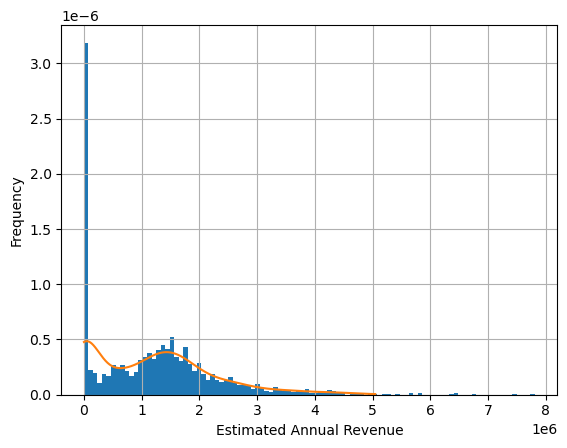

In [29]:
revenue_annual_alum = C1_alum * 7.3 * 354
revenue_annual_sauder = C1_sauder * 6.7 * 354
revenue_annual_total = revenue_annual_alum + revenue_annual_sauder

kde_rev = stats.gaussian_kde(revenue_annual_total)
plt.hist(revenue_annual_total,bins=100,density=True)
plt.xlabel('Estimated Annual Revenue')
plt.ylabel('Frequency')
t = np.linspace(0,revenue_annual.max(),3000)
plt.plot(t,kde_rev(t))
plt.grid(True)
plt.show()

In [36]:
# mean estimated revenue: 
mean_revenue = revenue_annual_total.mean()
print(f'Mean estimated revenue: ${mean_revenue:.2f}')

Mean estimated revenue: $1211797.53


To find the income, as requested, we multiply the yearly revenue by 0.685, based on research into raw material costs. 

In [37]:
mean_income = mean_revenue * 0.685
print(f'Mean estimated income: ${mean_income:.2f}')

Mean estimated income: $830081.31


#### Analyse & Assess

- There is a very high frequency of very low annual revenues in this model, as evidenced by the large spike close to 0 on the diagram above. This could be due to predictions of numbers of customers that are less than zero, which are then set to zero. This is a major flaw in our model's predictions. 

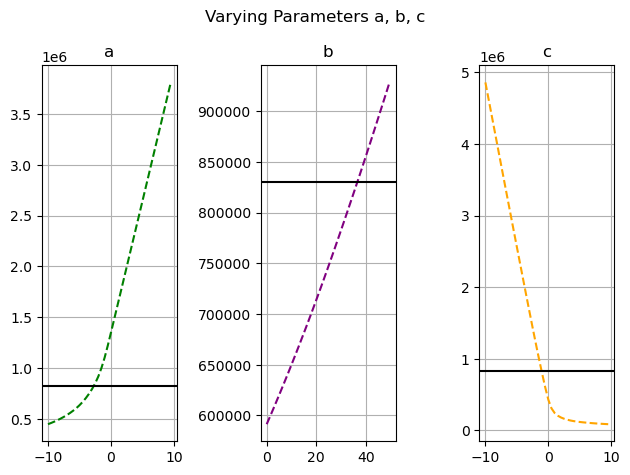

In [76]:
a_list = np.arange(-10, 10, 0.5)
income_a = []
for a in a_list:
    b=32
    c=-1
    num_alum = C0_alum + a * (T - T0)**2 - b * (P - P0) - c * (H - H0)**2
    C1_alum = np.maximum(num_alum, 0)
    num_sauder = C0_sauder + a * (T - T0)**2 - b * (P - P0) - c * (H - H0)**2
    C1_sauder = np.maximum(num_sauder, 0)
    revenue_annual_alum = C1_alum * 7.3 * 354
    revenue_annual_sauder = C1_sauder * 6.7 * 354
    revenue_annual_total = revenue_annual_alum + revenue_annual_sauder
    mean_income = float(revenue_annual_total.mean() * 0.685)
    income_a.append(mean_income)

b_list = np.arange(0, 50, 0.5)
income_b = []
for b in b_list:
    a=-3
    c=-1
    num_alum = C0_alum + a * (T - T0)**2 - b * (P - P0) - c * (H - H0)**2
    C1_alum = np.maximum(num_alum, 0)
    num_sauder = C0_sauder + a * (T - T0)**2 - b * (P - P0) - c * (H - H0)**2
    C1_sauder = np.maximum(num_sauder, 0)
    revenue_annual_alum = C1_alum * 7.3 * 354
    revenue_annual_sauder = C1_sauder * 6.7 * 354
    revenue_annual_total = revenue_annual_alum + revenue_annual_sauder
    mean_income = float(revenue_annual_total.mean() * 0.685)
    income_b.append(mean_income)

c_list = np.arange(-10, 10, 0.5)
income_c = []
for c in c_list:
    a=-3
    b=32
    num_alum = C0_alum + a * (T - T0)**2 - b * (P - P0) - c * (H - H0)**2
    C1_alum = np.maximum(num_alum, 0)
    num_sauder = C0_sauder + a * (T - T0)**2 - b * (P - P0) - c * (H - H0)**2
    C1_sauder = np.maximum(num_sauder, 0)
    revenue_annual_alum = C1_alum * 7.3 * 354
    revenue_annual_sauder = C1_sauder * 6.7 * 354
    revenue_annual_total = revenue_annual_alum + revenue_annual_sauder
    mean_income = float(revenue_annual_total.mean() * 0.685)
    income_c.append(mean_income)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Varying Parameters a, b, c')
ax1.plot(a_list, income_a, color='green', linestyle='--')
ax1.grid(True)
ax1.axhline(y = 830000, color='k')
ax1.set_title('a')
ax2.plot(b_list, income_b, color='purple', linestyle='--')
ax2.grid(True)
ax2.axhline(y = 830000, color='k')
ax2.set_title('b')
ax3.plot(c_list, income_c, color='orange', linestyle='--')
ax3.grid(True)
ax3.axhline(y = 830000, color='k')
ax3.set_title('c')

fig.tight_layout()

plt.show()